In [340]:
import os
import sys
import urllib
from collections import defaultdict

import requests

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time
from astropy.io import fits

import astroquery

from importlib import reload

%matplotlib inline
from matplotlib import style, pyplot as plt

# Initial setup 

In [3]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
copying SAGA/targets/target_selection.py -> build/lib/SAGA/targets
/Users/erik/projects/saga/erik


In [4]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga
from SAGA.database import external 

Adding /Users/erik/projects/saga/saga/build/lib to the python path


In [5]:
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'))

saga_host_catalog = saga.HostCatalog(saga_database)
saga_object_catalog = saga.ObjectCatalog(saga_database)

In [6]:
hosts_to_load = 'aat_2018'
host_id_label = 'ID_STR'
targethosts = saga_host_catalog.load(hosts_to_load)
targethosts[host_id_label] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

In [7]:
obs_start_date = Time('2018-6-10')

# Downloading of catalogs

In [420]:
sdsshosts = saga_host_catalog.load('flag0')
sdsshosts[host_id_label] = saga_host_catalog.resolve_id('flag0', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], sdsshosts[host_id_label])]


failed = external.download_catalogs_for_hosts(hosts_todl, external.SdssQuery, 
                                              saga_database.sdss_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

[06/11 22:30:51] Getting catalog for host nsa141465 ...
[06/11 22:30:51] Getting catalog for host nsa165082 ...
[06/11 22:30:51] Getting catalog for host nsa145398 ...
[06/11 22:30:51] Getting catalog for host nsa145729 ...
[06/11 22:30:52] casjob (SAGArvrz) submitted...
[06/11 22:38:58] casjob (SAGArvrz) finished, downloading data...
[06/11 22:39:35] Getting catalog for host nsa145879 ...
[06/11 22:39:36] casjob (SAGAfjdr) submitted...
[06/11 22:40:09] casjob (SAGAfjdr) finished, downloading data...
# failed = 0


In [397]:
deshosts = saga_host_catalog.load('has_des')
deshosts[host_id_label] = saga_host_catalog.resolve_id('has_des', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], deshosts[host_id_label])]

failed = external.download_catalogs_for_hosts(hosts_todl, external.DesQuery, 
                                              saga_database.des_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

[06/11 21:40:59] Getting catalog for host pgc2052 ...
[06/11 21:40:59] Getting catalog for host pgc3089 ...
[06/11 21:40:59] Getting catalog for host pgc64427 ...
[06/11 21:40:59] Getting catalog for host pgc66318 ...
[06/11 21:40:59] Getting catalog for host pgc66934 ...
[06/11 21:40:59] Getting catalog for host pgc67146 ...
[06/11 21:40:59] Getting catalog for host pgc67663 ...
[06/11 21:40:59] Getting catalog for host pgc67817 ...
[06/11 21:40:59] Getting catalog for host pgc68128 ...
[06/11 21:40:59] Getting catalog for host pgc69521 ...
[06/11 21:40:59] Getting catalog for host pgc70094 ...
[06/11 21:40:59] Getting catalog for host pgc71548 ...
[06/11 21:40:59] Getting catalog for host pgc71729 ...
# failed = 0


In [398]:
decalshosts = saga_host_catalog.load('has_decals')
decalshosts[host_id_label] = saga_host_catalog.resolve_id('has_decals', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], decalshosts[host_id_label])]

failed = external.download_catalogs_for_hosts(hosts_todl, external.DecalsPrebuilt, 
                                              saga_database.decals_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.count_nonzero(failed))

[06/11 21:40:59] Getting catalog for host nsa3469 ...
[06/11 21:40:59] Getting catalog for host nsa141465 ...
[06/11 21:41:24] Getting catalog for host nsa165082 ...
[06/11 21:41:49] Getting catalog for host nsa145398 ...
[06/11 21:42:15] Getting catalog for host nsa145729 ...
[06/11 21:42:34] Getting catalog for host nsa145879 ...
# failed = 0


## Base catalogs if needed

In [394]:
saga_object_catalog.build_and_write_to_database('aat_2018', overwrite=False)

[06/11 21:29:53] Base catalog v2 for pgc2052 already exists. (1/19)
[06/11 21:29:53] Base catalog v2 for pgc3089 already exists. (2/19)
[06/11 21:29:53] Base catalog v2 for nsa3469 already exists. (3/19)
[06/11 21:29:53] Base catalog v2 for nsa141465 already exists. (4/19)
[06/11 21:29:53] Base catalog v2 for nsa165082 already exists. (5/19)
[06/11 21:29:53] Base catalog v2 for nsa145398 already exists. (6/19)
[06/11 21:29:53] Base catalog v2 for nsa145729 already exists. (7/19)
[06/11 21:29:53] Base catalog v2 for nsa145879 already exists. (8/19)
[06/11 21:29:53] Base catalog v2 for pgc64427 already exists. (9/19)
[06/11 21:29:53] Base catalog v2 for pgc66318 already exists. (10/19)
[06/11 21:29:53] Base catalog v2 for pgc66934 already exists. (11/19)
[06/11 21:29:53] Base catalog v2 for pgc67146 already exists. (12/19)
[06/11 21:29:53] Base catalog v2 for pgc67663 already exists. (13/19)
[06/11 21:29:53] Base catalog v2 for pgc67817 already exists. (14/19)
[06/11 21:29:53] Base catal

# Generate AAT-appropriate target catalogs 

In [8]:
saga_database['manual_targets_aat2018a'].local.path = 'aat_targets_jun2018/manual_targets.csv'

saga_targets = saga.TargetSelection(saga_database, 
                                    manual_selected_objids='manual_targets_aat2018a',
                                    gmm_parameters={'sdss':'gmm_parameters_no_outlier', 
                                                    'des': 'gmm_parameters_no_outlier_no_u'}, 
                                    version=2)

acats = {}
tcats = {}

In [275]:
def get_gaia_guidestars(hostname, magrng=(12.5, 13.5),
                        matchmagrng=(16, 17), d_matchmag=1, matchtol0=1*u.arcsec,
                        verbose=True, neighbor_cut=30*u.arcsec, nmagdown=4.5):
    """
    `magrng` is the range of magnitudes to actually select on.  It's ~r-band, based on the
    Evans et al. 2018 r-to-G conversion
    """
    print = __builtin__.print
    if not verbose:
        print = lambda *args, **kwargs:None
        
    host = saga_host_catalog.load_single(hostname)
    obj_cat = saga_object_catalog.load(hostname)[0]
    omag = obj_cat['r_mag']
    gaia_cat = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(hostname))
    gaia_sc = SkyCoord(gaia_cat['ra'], gaia_cat['dec'])
    gmag = gaia_cat['phot_g_mean_mag']
    
    omsk = (matchmagrng[0]<omag)&(omag<matchmagrng[1])
    gmsk = ((matchmagrng[0]-d_matchmag)<gmag)&(gmag<(matchmagrng[1]+d_matchmag))
    oscmsk = obj_cat['coord'][omsk]
    gscmsk = gaia_sc[gmsk]
    
    idx, d2d, _ = oscmsk.match_to_catalog_sky(gscmsk)
    sepmsk = d2d < matchtol0
    
    dra = (oscmsk[sepmsk].ra - gscmsk[idx][sepmsk].ra).to(u.arcsec)
    ddec = (oscmsk[sepmsk].dec - gscmsk[idx][sepmsk].dec).to(u.arcsec)
    offset = np.mean(dra), np.mean(ddec)
    
    print("Object catalog to Gaia offset:", offset, 'from', np.sum(sepmsk), 
          'objects ({:.1%})'.format(np.sum(sepmsk)/len(sepmsk)))
    
    #this polynomial is from Evans et al. 2018 for the G to r conversion
    Gmr_coeffs = (-0.1856, 0.1579, 0.02738, -0.0550)
    Gmr = np.polyval(Gmr_coeffs[::-1], gaia_cat['bp_rp'])
    gaia_cat['g_as_r_mag'] = gmag - Gmr
    
    gmsk = (magrng[0] < gaia_cat['g_as_r_mag'])&(gaia_cat['g_as_r_mag'] < magrng[1])
    gstars = gaia_cat[gmsk]
    print('Found', len(gstars), 'Gaia guide stars')
    
    if neighbor_cut is not None:
        possible_neighbor_stars = gaia_cat[gaia_cat['g_as_r_mag'] < magrng[1]+nmagdown]
        nsc = SkyCoord(possible_neighbor_stars['ra'], possible_neighbor_stars['dec'])
        gsc = SkyCoord(gstars['ra'], gstars['dec'])
        idx, d2d, _ = gsc.match_to_catalog_sky(nsc, 2)
        neighbor_present = d2d < neighbor_cut
        print(np.sum(neighbor_present), 'Have a brightish neighbor.  Removing them.')
        gstars = gstars[~neighbor_present]

    tab = table.Table({
        'TargetName': gstars['source_id'],
        'RA': (u.Quantity(gstars['ra']) + offset[0]),
        'Dec': (u.Quantity(gstars['dec']) + offset[1]),
        'TargetType': np.repeat('F', len(gstars)),
        'Priority': np.repeat(9, len(gstars)),
        'Magnitude':gstars['g_as_r_mag'],
        '0': np.repeat(0, len(gstars)),
        'Notes': np.repeat('guide_gaia', len(gstars)),
    })
    tab.meta['dra'] = dra
    tab.meta['ddec'] = ddec
    tab.meta['offset'] = offset
    tab.meta['gstarcat'] = gstars
    return tab

In [10]:
def get_sdss_guidestars(hostname):
    host = saga_host_catalog.load_single(hostname)
    obj_cat = saga_object_catalog.load(hostname)[0]
    r = obj_cat['r_mag']
    msk = (12.5<r)&(r<14)&~obj_cat['is_galaxy']&(obj_cat['RHOST_ARCM']>15)
    starcat = obj_cat[msk]
    
    return table.Table({
        'TargetName': starcat['OBJID'],
        'RA': starcat['RA'],
        'Dec': starcat['DEC'],
        'TargetType': np.repeat('F', len(starcat)),
        'Priority': np.repeat(9, len(starcat)),
        'Magnitude': starcat['r_mag'],
        '0': np.repeat(0, len(starcat)),
        'Notes': np.repeat('guide', len(starcat)),
    })

In [45]:
from astropy.coordinates import Angle

def write_fld_file(target_catalog, host, obstime, fn):
    hostname = host[host_id_label]
    target_catalog.write(fn,
                         delimiter=' ',
                         quotechar='"',
                         format='ascii.fast_commented_header',
                         overwrite=True,
                         formats={
                            'RA': lambda x: Angle(x, 'deg').wrap_at(360*u.deg).to_string('hr', sep=' ', precision=2), # pylint: disable=E1101
                            'Dec': lambda x: Angle(x, 'deg').to_string('deg', sep=' ', precision=2),
                            'Magnitude': '%.2f',
                         })
    with open(fn) as fh:
        content = fh.read()
    with open(fn, 'w') as fh:
        fh.write('LABEL ' + hostname + ' master catalog\n')
        fh.write('UTDATE  {yr} {mo:02} {day:02}\n'.format(yr=obstime.datetime.year,
                                                        mo=obstime.datetime.month,
                                                        day=obstime.datetime.day))
        censtr = host['coord'].to_string('hmsdms', sep=' ', precision=2, alwayssign=True)
        fh.write('CENTRE  ' + censtr + '\n')
        fh.write('EQUINOX J2000.0\n')
        fh.write('# End of Header\n\n')
        fh.write(content.replace('"', ''))

In [361]:
def infer_radec_cols(table):
    raname = decname = None
    for cnm in table.colnames:
        if cnm.lower()=='ra':
            raname = cnm
        elif cnm.lower()=='dec':
            decname = cnm
    return raname, decname

In [362]:
def make_decals_viewer_cutouts(table, survey='sdss', ncols=3, zoom=15, size=120, namecol=None, dhtml=True):
    """
    Zoom of 15 is ~1"/pixel, so ~2' across with defaults
    """
    template_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={ra:.7}&dec={dec:.7}&zoom={zoom}&layer={layer}&size={size}'
    
    raname, decname = infer_radec_cols(table)
    
    entries = []
    for row in table:
        imgurl = template_url.format(ra=row[raname], dec=row[decname], layer=survey, size=size, zoom=zoom)
        viewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row[raname], row[decname])
        
        namestr = '' if namecol is None else (str(row[namecol]) + '<br>')
        entries.append('{}<a href="{}"><img src="{}"></a>'.format(namestr, viewurl, imgurl))
        
    entryrows = [[]]
    while entries:
        entry = entries.pop(0)
        if len(entryrows[-1]) >= ncols:
            entryrows.append([])
        entryrows[-1].append(entry)
    entryrows[-1].extend(['']*(ncols-len(entryrows[-1])))
    
    tabrows = ['<td>{}</td>'.format('</td><td>'.join(erow)) for erow in entryrows]

    htmlstr = """
    <table>
    <tr>{}</tr>
    </table>
    """.format('</tr>\n<tr>'.join(tabrows))

    if dhtml:
        from IPython import display
        return display.HTML(htmlstr)
    else:
        return htmlstr

In [389]:
def make_des_cutouts_file(table, copytoclipboard=True, showtable=False):
    raname, decname = infer_radec_cols(table)
    
    entries = []
    for row in table:
        entries.append('{:.5f},{:.5f}'.format(row[raname], row[decname]))
        
    htmlstr = """
    Paste the coords as value in  
    <a href="https://des.ncsa.illinois.edu/easyweb/cutouts">the DES cutout service</a>
    """
    tablestr = """<br>
    <table>
    <tr><td>{}</td></tr>
    </table>
    """.format('</td></tr>\n<tr><td>'.join(entries))
    if showtable:
        htmlstr += tablestr
    
    if copytoclipboard:
        import platform
        text = '\n'.join(entries)
        if platform.system() == 'Darwin':
            clipproc = os.popen('pbcopy', 'w')
            clipproc.write(text)
            clipproc.close()
            print('Copied to clipboard')
        elif platform.system() == 'Linux':
            clipproc = os.popen('xsel -i', 'w')
            clipproc.write(text)
            clipproc.close()
            print('Copied to clipboard')
        else:
            raise OSError("Not on a mac or linux, so can't use clipboard. ")
        
    from IPython import display
    return display.HTML(htmlstr)
    
def show_des_cutouts(table, jobname, username='eteq', ncols=3, namecol=None, force_size=(128, 128), dhtml=True):
    base_url = 'https://des.ncsa.illinois.edu'
    
    list_url = base_url + '/easyweb/static/workdir/{}/{}/list.json'.format(username, jobname)
    print(list_url)
    list_json = requests.get(list_url).json()
    img_urls = [base_url+img['name'] for img in list_json]
    
    if len(table) != len(img_urls):
        raise ValueError('table and job length do not match!')
    raname, decname = infer_radec_cols(table)
    
    sizestr = '' if force_size is None else ('height="{}" width="{}"'.format(force_size[1], force_size[0]))
    entries = []
    for row, imgurl in zip(table, img_urls):
        viewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row[raname], row[decname])
        
        namestr = '' if namecol is None else (str(row[namecol]) + '<br>')
        entries.append('{}<a href="{}"><img src="{}"{}></a>'.format(namestr, viewurl, imgurl, sizestr))
        
    entryrows = [[]]
    while entries:
        entry = entries.pop(0)
        if len(entryrows[-1]) >= ncols:
            entryrows.append([])
        entryrows[-1].append(entry)
    entryrows[-1].extend(['']*(ncols-len(entryrows[-1])))
    
    tabrows = ['<td>{}</td>'.format('</td><td>'.join(erow)) for erow in entryrows]

    htmlstr = """
    <table>
    <tr>{}</tr>
    </table>
    """.format('</tr>\n<tr>'.join(tabrows))

    if dhtml:
        from IPython import display
        return display.HTML(htmlstr)
    else:
        return htmlstr


# Night 1

In [12]:
import aat

In [190]:
targethosts[targethosts['NSAID'] == 3469]

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,coord,ID_STR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,str9
--,3469,185.975,-3.44293,40284,19609,4348,-1,2004.28,29.8369,12.7268,12.3164,11.9917,11.64,8.899,0.023,16416,-23.4748,-19.647,58.7146,3.91973,--,0.814071,185.975,-3.44293,12235398-0326345,2004.28,-1,29.8369,0.115617,14.4597,0.00366845,0.150456,-18.0852,12.8953,0.000715916,0.117234,-19.6124,12.0373,0.000568001,0.0811022,-20.4264,11.5849,0.000714507,0.0602676,-20.8572,11.225,0.00106884,0.044828,-21.2002,9.977,0.014,0.0251648,-22.4216,9.272,0.013,0.0159365,-23.1188,8.912,0.021,0.010719,-23.4597,10200000000,1.40497,-23.4748,0.0,1.0,0.0,"185.975,-3.44293",nsa3469


## nsa3469

In [99]:
for host in targethosts[targethosts['NSAID'] == 3469]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa3469
# of flux stars = 143
# of sky fibers = 100
# of Priority=1 targets = 561
# of Priority=2 targets = 9
# of Priority=3 targets = 16
# of Priority=4 targets = 50
# of Priority=5 targets = 511
# of Priority=6 targets = 144
# of Priority=7 targets = 4
# of Priority=8 targets = 0
# of Priority=9 targets = 243


/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:54: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Writing aat_targets_jun2018/nsa3469_master.fld


In [27]:
aat.subsample_from_master_fld('aat_targets_jun2018/nsa3469_master.fld', 
                              'aat_targets_jun2018/nsa3469_1.fld',
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5)

Total remaining in each priority (5 fluxes, 141 guides, and 100 skies not included):
{1: 561, 2: 9, 3: 16, 4: 50, 5: 511, 6: 144, 7: 4, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%


Note: was not able to inspect the skies *before* observing.  Below is to know which might be a problem

In [ ]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='decals-dr5', ncols=6, 
                           zoom=16, namecol='TargetName')

7, 22, 81, and 76 remove for future.  None used in true config.

## nsa145729

In [102]:
for host in targethosts[targethosts['NSAID'] == 145729]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    #acat = saga.targets.prepare_aat_catalog(tcat, 'aat_targets_jun2018/{}.cat'.format(hostname))
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa145729
# of flux stars = 318
# of sky fibers = 100
# of Priority=1 targets = 536
# of Priority=2 targets = 16
# of Priority=3 targets = 14
# of Priority=4 targets = 50
# of Priority=5 targets = 259
# of Priority=6 targets = 105
# of Priority=7 targets = 3
# of Priority=8 targets = 2
# of Priority=9 targets = 418
Writing aat_targets_jun2018/nsa145729_master.fld


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [83]:
aat.subsample_from_master_fld('aat_targets_jun2018/nsa145729_master.fld', 
                              'aat_targets_jun2018/nsa145729_1.fld',
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5)

Total remaining in each priority (5 fluxes, 196 guides, and 100 skies not included):
{1: 536, 2: 16, 3: 14, 4: 50, 5: 259, 6: 105, 7: 3, 8: 2, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


In [251]:
aat.imagelist_fld_targets('aat_targets_jun2018/{}_1.fld'.format(hostname))

'name ra dec\n1237655693551797043 224.28362499999997 -1.0167166666666667\n1237648702984356321 224.20654166666662 -1.0672416666666666\n1237655499210425196 224.52899999999997 -1.6290027777777778\n1237655499210424420 224.49804166666664 -1.5100833333333332\n1237648703521489922 224.88395833333328 -0.6706027777777778\n1237648703521489868 224.8677083333333 -0.6261666666666666\n1237655692478251284 224.83333333333331 -1.8719555555555556\n1237655693015253946 225.08166666666665 -1.3044916666666666\n3255080000000003744 225.0220833333333 -0.9379694444444444\n1237648702984880207 225.44270833333331 -1.098197222222222\n1237648703521554976 225.01366666666664 -0.73385\n1237648702984159385 223.8535833333333 -1.0734861111111111\n3283850000000001411 224.38399999999996 -0.5618666666666667\n3269470000000001139 224.9160833333333 -0.8147527777777778\n3298240000000003919 224.08645833333333 -0.23843333333333333\n1237648703521685692 225.35679166666665 -0.79815\n1237648704058425599 224.98370833333328 -0.411225\n41

In [103]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='decals-dr5', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


If future obs come up, removing 93, 76, 43, 15, 29.  None on actual observed config.

## pgc66318

In [248]:
for host in targethosts[targethosts['PGC'] == 66318]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat, sky_fiber_needed=150)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc66318
# of flux stars = 427
# of sky fibers = 150
# of Priority=1 targets = 203
# of Priority=2 targets = 80
# of Priority=3 targets = 105
# of Priority=4 targets = 50
# of Priority=5 targets = 181
# of Priority=6 targets = 86
# of Priority=7 targets = 16
# of Priority=8 targets = 30
# of Priority=9 targets = 577
Object catalog to Gaia offset: (<Angle -0.08669275 arcsec>, <Angle 0.07036883 arcsec>)
Found 421 Gaia guide stars
7 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc66318_master.fld


Visually check guide stars and sky fibers.  Remove any skies that are bad.

In [245]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], survey='unwise-w1w2',ncols=6,namecol='TargetName')

6478961056530626176,6479738681833663872,6478928380419347328,6478659618545799680,6478961228329316352,6478753351911909632
6478741257283939840,6478806845728235008,6478877734164952960,6479561115001324544,6478954249006008192,6478834750132160128
6479087500367941888,6479619865857498752,6478768813794106112,6478876222336486144,6478954317725484288,6478638414291055872
6478498402653437312,6478566881612032384,6478804754080497024,6479703536117057024,6479087328569249408,6478737993108789248


In [249]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 0 18 23 37 50 56 59 68 69 73 86 87 91 94 99 110 114 115 120 122 126 132 134 138 143 147 148

In [252]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 123 skies not included):
{1: 203, 2: 80, 3: 105, 4: 50, 5: 181, 6: 86, 7: 16, 8: 30, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


Note that `aat_targets_jun2018/pgc66318_1.fld` ended up getting made *before* the sky-fiber cleanup due to time constraints.  But it appears that the fibers assigned to the actual observations are clear?

## pgc66934

In [46]:
for host in targethosts[targethosts['PGC'] == 66934]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc66934
# of flux stars = 268
# of sky fibers = 100
# of Priority=1 targets = 241
# of Priority=2 targets = 135
# of Priority=3 targets = 94
# of Priority=4 targets = 50
# of Priority=5 targets = 170
# of Priority=6 targets = 65
# of Priority=7 targets = 18
# of Priority=8 targets = 20
# of Priority=9 targets = 368
Object catalog to Gaia offset: (<Angle -0.12299029 arcsec>, <Angle 0.1454588 arcsec>)
Writing aat_targets_jun2018/pgc66934_master.fld


In [60]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

6577860306382962944,6577596011275249664,6576368990658589184,6577602711424241664,6576324116840171136,6576310544743577472
6576359438651334272,6577792274100915968,6576289860181064064,6577860065864787456,6576090539338695808,6576271718239143936
6577644664664848384,6577863428822858112,6576256909191882752,6577523409148020480,6576356999109865856,6577525432076225024
6576063807462249728,6577569519916995200,6577535774357467776,6576065800326958464,6577605666361732352,6576080093978198016


6576299790145393152 is problematic because it's right next to a much brighter star.  Will remove.

In [61]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 13, 16, 26, 28, 57, 59

In [62]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 94 skies not included):
{1: 241, 2: 135, 3: 94, 4: 50, 5: 170, 6: 65, 7: 18, 8: 20, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


## PGC 2052 

In [164]:
for host in targethosts[targethosts['PGC'] == 2052]:
    hostname = host[host_id_label]
    print(hostname)
    tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc2052
# of flux stars = 70
# of sky fibers = 100
# of Priority=1 targets = 748
# of Priority=2 targets = 12
# of Priority=3 targets = 82
# of Priority=4 targets = 50
# of Priority=5 targets = 556
# of Priority=6 targets = 243
# of Priority=7 targets = 38
# of Priority=8 targets = 23
# of Priority=9 targets = 170
Object catalog to Gaia offset: (<Angle -0.19705932 arcsec>, <Angle 0.12130509 arcsec>)
Found 186 Gaia guide stars
4 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc2052_master.fld


In [165]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

2343373983930097408,2343091134563836672,2319330104172069632,2343091787398863232,2322213848294035840,2319259804147387136
2319032853780052864,2343345568426552320,2343074160853088384,2322331392958701312,2319348727150260608,2322213573416129024
2322378392785359872,2322328850338075648,2343086839596537856,2343313064114013056,2319349586143693568,2319289697119676416
2343335363584231168,2319248809031078656,2343335775901103872,2343279906966486016,2346391249995115648,2319338655451399680


In [166]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removed 17, 28, 50, 81, 91

In [168]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 95 skies not included):
{1: 748, 2: 12, 3: 82, 4: 50, 5: 556, 6: 243, 7: 38, 8: 23, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


# Night 2 

## nsa141465 

In [223]:
for host in targethosts[targethosts['NSAID'] == 141465]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa141465
# of flux stars = 128
# of sky fibers = 100
# of Priority=1 targets = 331
# of Priority=2 targets = 7
# of Priority=3 targets = 14
# of Priority=4 targets = 50
# of Priority=5 targets = 228
# of Priority=6 targets = 95
# of Priority=7 targets = 7
# of Priority=8 targets = 2
# of Priority=9 targets = 228


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Writing aat_targets_jun2018/nsa141465_master.fld


In [229]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))], 
                           survey='sdss',ncols=6,namecol='TargetName')

1237650372095443062,1237650371558637575,1237650371021570066,1237650370485354549,1237650371022290959,1237650372095836257
1237650761319776361,1237650371559096381,1237650761856647253,1237650762930716684,1237650371021635631,1237648720160292929
1237650372095967250,1237650371021766718,1237650370484895791,1237650762930192398,1237650372095443061,1237648720160096345
1237650761320169543,1237650370485026857,1237650762930454573,1237650370485354586,1237650762930978838,1237650371022291006
1237648702967840810,1237650761320038423,1237650762930257978,1237650371021766721,1237650370484764729,1237650762930585619
1237650372095836209,1237650371021766659,1237650762930454563,1237648702968365111,1237650372095770641,1237650762393583623
1237650762393976988,1237650371021635610,1237650371021897737,1237650371022028929,1237650370485026840,1237650762930389010
1237650762394042391,1237650762930257991,1237650762393321543,1237650372095574027,1237648702967971891,1237650761857040440
1237650761856974928,1237650761320235030,1237650371021766741,1237650372095574046,1237648702967971870,1237650369948286983
1237650372095377524,1237650761856516147,1237650762930454603,1237650762930716700,1237650371021570181,1237650372096032800
1237650761319972869,1237650371021766758,1237650372095836214,1237650762393321487,1237650370485223468,1237650370485092378


Remove 1237650762930913293, 1237648702968102985, 1237650762930913292

In [225]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='sdss', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Remove 16

In [235]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 99 skies not included):
{1: 331, 2: 7, 3: 14, 4: 50, 5: 228, 6: 95, 7: 7, 8: 2, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


## nsa145879 

In [238]:
for host in targethosts[targethosts['NSAID'] == 145879]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa145879


/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:54: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]


# of flux stars = 283
# of sky fibers = 100
# of Priority=1 targets = 696
# of Priority=2 targets = 32
# of Priority=3 targets = 35
# of Priority=4 targets = 50
# of Priority=5 targets = 516
# of Priority=6 targets = 205
# of Priority=7 targets = 8
# of Priority=8 targets = 0
# of Priority=9 targets = 383


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Writing aat_targets_jun2018/nsa145879_master.fld


In [239]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))], 
                           survey='sdss',ncols=6,namecol='TargetName')

1237655467524620437,1237648705670348971,1237648721251532818,1237648705670021225,1237648721788534860,1237648705133543524
1237655468061884470,1237651735777509383,1237655467524882444,1237651735777706099,1237648721788207203,1237648704596148376
1237648704596410386,1237655468061884508,1237651735777837108,1237655468061556835,1237655467524554806,1237648721788207137
1237655467525079055,1237648704596475927,1237655467524882532,1237648704596607019,1237651735777575169,1237655468061753410
1237651735777443986,1237648704059473995,1237655468061556819,1237651735777968298,1237651735777837078,1237648705670348882
1237651735777837162,1237648705669955692,1237648705670021186,1237648704596279421,1237655468061687864,1237648721251664029
1237648721251467366,1237648721251336362,1237651735777837140,1237648721788665915,1237648705670414516,1237651735777640504
1237648704596672591,1237651735777574918,1237648705133609080,1237648704059605130,1237655468061884603,1237648705669759076
1237648704059539579,1237651735777574919,1237655468061360163,1237655468061687916,1237655467524423728,1237648705670348845
1237655468061491340,1237648721788665953,1237648721788469326,1237648705670348929,1237648704596607104,1237648704596082778
3370370000000000939,1237655467524554834,1237655468061622279,1237648704596279317,1237648704596607062,1237655468061753456


Remove 1237655467525144674  1237655467524620357 1237648704596082789 1237648704596279461 1237655468061556867 1237648704596082818 1237648705669824621 1237648705669824675

In [240]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='sdss', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Remove 53 54 66 70

In [243]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 96 skies not included):
{1: 696, 2: 32, 3: 35, 4: 50, 5: 516, 6: 205, 7: 8, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%


## pgc66318

Didn't get it in night 1, so re-doing it.  But re-working files with improvements to the Gaia star-finding function.

In [295]:
for host in targethosts[targethosts['PGC'] == 66318]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat, sky_fiber_needed=125)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc66318
# of flux stars = 427
# of sky fibers = 125
# of Priority=1 targets = 203
# of Priority=2 targets = 80
# of Priority=3 targets = 105
# of Priority=4 targets = 50
# of Priority=5 targets = 181
# of Priority=6 targets = 86
# of Priority=7 targets = 16
# of Priority=8 targets = 30
# of Priority=9 targets = 552
Object catalog to Gaia offset: (<Angle -0.11968757 arcsec>, <Angle 0.14139283 arcsec>) from 1884 objects (73.3%)
Found 234 Gaia guide stars
83 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc66318_master.fld


In [297]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

6479277814662814464,6479343514778466432,6478904569120798080,6478688068409252992,6478744418379866752,6478931640298176384
6478886938278564992,6479660513427993600,6478934359013926784,6478602096047618176,6478702602578635392,6478802035365863680
6479563142225881344,6478802692496198272,6479707620630172160,6478796194209339776,6479707934163581696,6478736545703541376
6478921783349575424,6479557026192452096,6478967928478282112,6478687415574208512,6478908211252990720,6479614991071156736


In [298]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 0 19 20 25 37 43 52 63 76 77 81 84 93 99 100 103 105 110  116 117 120 123

In [300]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 103 skies not included):
{1: 203, 2: 80, 3: 105, 4: 50, 5: 181, 6: 86, 7: 16, 8: 30, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


## pgc67817

In [307]:
for host in targethosts[targethosts['PGC'] == 67817]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat, sky_fiber_needed=125)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

pgc67817
# of flux stars = 242
# of sky fibers = 125
# of Priority=1 targets = 301
# of Priority=2 targets = 106
# of Priority=3 targets = 71
# of Priority=4 targets = 50
# of Priority=5 targets = 230
# of Priority=6 targets = 70
# of Priority=7 targets = 45
# of Priority=8 targets = 1
# of Priority=9 targets = 367
Object catalog to Gaia offset: (<Angle -0.12210635 arcsec>, <Angle 0.17147205 arcsec>) from 1391 objects (75.2%)
Found 162 Gaia guide stars
55 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc67817_master.fld


In [308]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))[:24]], 
                           survey='unwise-w1w2',ncols=6,namecol='TargetName')

6571247980892681600,6570851469511738496,6570809207033518464,6571181632237865984,6570986125326473472,6570930703068492160
6570983445266869504,6571387962466837888,6571043437369952128,6571174244894099456,6568323726639453568,6571080305369334272
6571016258817092224,6570814979469632000,6571211147253175168,6570793504633072640,6571149368443509248,6567917903769235968
6570808275023968384,6571342298374534784,6567911890814969216,6571344737915960064,6567907355329512704,6571096076489273600


In [309]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='unwise-w1w2', ncols=6, 
                           zoom=16, namecol='TargetName')

0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


Removing 1 3 7 10 13  22 25 29  35 36 38 41 42 50 54 56  63 69 71 72 76  80 81  85 92 97 98 107 117 120

Testing alternative sky cutouts using DES service

In [377]:
make_des_cutouts_file(acat[acat['Notes']=='sky'])

Copied to clipboard


In [391]:
show_des_cutouts(acat[acat['Notes']=='sky'], 'dc3ec44c-2dd2-4768-bde1-ce088eb5124f', 
                 ncols=6, namecol='TargetName',  dhtml=True)

https://des.ncsa.illinois.edu/easyweb/static/workdir/eteq/dc3ec44c-2dd2-4768-bde1-ce088eb5124f/list.json


0,1,2,3,4,5
6,7,8,9,10,11
12,13,14,15,16,17
18,19,20,21,22,23
24,25,26,27,28,29
30,31,32,33,34,35
36,37,38,39,40,41
42,43,44,45,46,47
48,49,50,51,52,53
54,55,56,57,58,59
60,61,62,63,64,65


In [318]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:np.inf,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

Total remaining in each priority (5 fluxes, 100 guides, and 95 skies not included):
{1: 301, 2: 106, 3: 71, 4: 50, 5: 230, 6: 70, 7: 45, 8: 1, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: 100.0, 9: None}%


# Night 3 

## nsa3469 (_2)

In [439]:
saga_object_catalog.build_and_write_to_database('NSA3469', overwrite=True)

[06/11 23:02:06] [WARNING] Not found: des catalog for nsa3469.
[06/11 23:02:09] Use SDSS, DECALS to build base catalog v2 for nsa3469 (1/1)


/Users/erik/projects/saga/saga/build/lib/SAGA/objects/build2.py:149: RuntimeWarning: invalid value encountered in true_divide
  catalog['radius_err'] = np.hypot(catalog['FRACDEV']**2.0 / catalog['SHAPEDEV_R_IVAR'], (1.0 - catalog['FRACDEV'])**2.0 / catalog['SHAPEEXP_R_IVAR'])
/Users/erik/projects/saga/saga/build/lib/SAGA/objects/build2.py:149: RuntimeWarning: divide by zero encountered in true_divide
  catalog['radius_err'] = np.hypot(catalog['FRACDEV']**2.0 / catalog['SHAPEDEV_R_IVAR'], (1.0 - catalog['FRACDEV'])**2.0 / catalog['SHAPEEXP_R_IVAR'])
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[06/11 23:02:52] Write base catalog to ./base_catalogs/base_v2_nsa3469.fits.gz


Previously:
```
# of flux stars = 283
# of sky fibers = 100
# of Priority=1 targets = 696
# of Priority=2 targets = 32
# of Priority=3 targets = 35
# of Priority=4 targets = 50
# of Priority=5 targets = 516
# of Priority=6 targets = 205
# of Priority=7 targets = 8
# of Priority=8 targets = 0
# of Priority=9 targets = 383
```

In [551]:
for host in targethosts[targethosts['NSAID'] == 3469]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat)
    
    guidestars = get_sdss_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master2.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    write_fld_file(writecat, host, obs_start_date, fnout)

nsa3469
# of flux stars = 143
# of sky fibers = 100
# of Priority=1 targets = 561
# of Priority=2 targets = 9
# of Priority=3 targets = 16
# of Priority=4 targets = 50
# of Priority=5 targets = 511
# of Priority=6 targets = 144
# of Priority=7 targets = 4
# of Priority=8 targets = 0
# of Priority=9 targets = 243


/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:54: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Writing aat_targets_jun2018/nsa3469_master2.fld


For other ones we could just re-use the old guide/sky, but in this case the method has improved so we check again

In [ ]:
make_decals_viewer_cutouts(guidestars[np.random.permutation(len(guidestars))], 
                           survey='sdss',ncols=6,namecol='TargetName')

In [ ]:
make_decals_viewer_cutouts(acat[acat['Notes']=='sky'], survey='sdss', ncols=6, 
                           zoom=16, namecol='TargetName')

In [ ]:
aat.subsample_from_master_fld('aat_targets_jun2018/{}_master2.fld'.format(hostname), 
                              'aat_targets_jun2018/{}_1.fld'.format(hostname),
                             {1:0,2:np.inf,3:np.inf,4:np.inf,
                              5:np.inf,6:np.inf,7:np.inf,8:np.inf,9:np.inf},
                              nflux=5, nguides=100)

### Experiment: 66934 

In [558]:
saga_object_catalog.build_and_write_to_database('pgc66934', overwrite=True)

[06/12 03:04:49] [WARNING] Not found: sdss catalog for pgc66934.
[06/12 03:04:50] [WARNING] Not found: decals catalog for pgc66934.
[06/12 03:04:50] Use DES to build base catalog v2 for pgc66934 (1/1)


[06/12 03:05:23] Write base catalog to ./base_catalogs/base_v2_pgc66934.fits.gz


Previously:
```
pgc66934
# of flux stars = 268
# of sky fibers = 100
# of Priority=1 targets = 241
# of Priority=2 targets = 135
# of Priority=3 targets = 94
# of Priority=4 targets = 50
# of Priority=5 targets = 170
# of Priority=6 targets = 65
# of Priority=7 targets = 18
# of Priority=8 targets = 20
# of Priority=9 targets = 368
```

In [559]:
for host in targethosts[targethosts['PGC'] == 66934]:
    hostname = host[host_id_label]
    print(hostname)
    tcats[hostname] = tcat = saga_targets.build_target_catalogs(hostname, return_as='list').pop()
    acats[hostname] = acat = saga.targets.prepare_aat_catalog(tcat, sky_fiber_needed=125)
    
    guidestars = get_gaia_guidestars(hostname)
    writecat = table.vstack([acat, guidestars])
    
    fnout = 'aat_targets_jun2018/{}_master2.fld'.format(hostname)
    print('Writing', fnout)
    writecat['Notes'] = [n.title() for n in writecat['Notes']]
    #write_fld_file(writecat, host, obs_start_date, fnout)

pgc66934
# of flux stars = 268
# of sky fibers = 125
# of Priority=1 targets = 241
# of Priority=2 targets = 135
# of Priority=3 targets = 94
# of Priority=4 targets = 50
# of Priority=5 targets = 170
# of Priority=6 targets = 65
# of Priority=7 targets = 18
# of Priority=8 targets = 20
# of Priority=9 targets = 393
Object catalog to Gaia offset: (<Angle -0.12453722 arcsec>, <Angle 0.14460583 arcsec>) from 1575 objects (72.3%)
Found 184 Gaia guide stars
63 Have a brightish neighbor.  Removing them.
Writing aat_targets_jun2018/pgc66934_master2.fld


# Planning 

In [105]:
import astroplan
import astroplan.plots

In [156]:
targs = [astroplan.FixedTarget(host['coord'], host['ID_STR']) for host in targethosts]

In [165]:
destargs = [t for t, h in zip(targs, targethosts) if h['des_dr1']]
nsatargs = [t for t, h in zip(targs, targethosts) if not h['des_dr1']]

In [106]:
aatobs = astroplan.Observer.at_site('aao')

In [158]:
run_start = aatobs.midnight(obs_start_date, 'next')
run_end = aatobs.midnight(Time('2018-6-15'), 'next')
run_mid = aatobs.midnight(Time((run_start.jd + run_end.jd)/2, format='jd'))

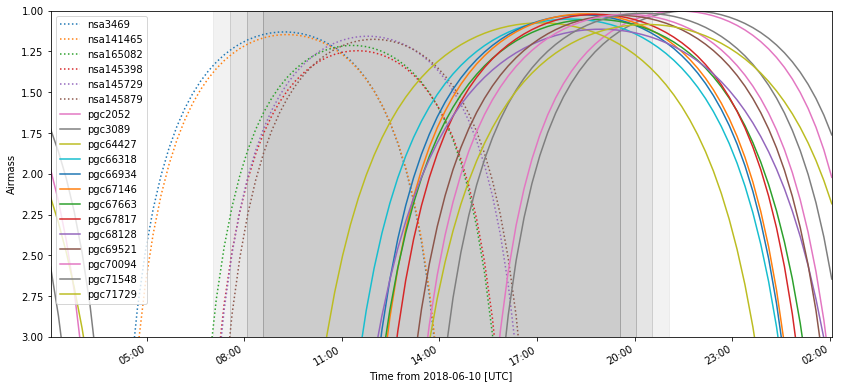

In [171]:
plt.figure(figsize=(14, 6))
astroplan.plots.plot_airmass(nsatargs, aatobs, run_start,
                             style_kwargs=dict(linestyle=':'))
astroplan.plots.plot_airmass(destargs, aatobs, run_start, 
                             style_kwargs=dict(linestyle='-'),
                             brightness_shading=True)
plt.legend(loc=0)

In [76]:
{host['ID_STR']:host['coord'].to_string('hmsdms') for host in targethosts}

{'nsa141465': '12h28m50.64s -01d56m21.048s',
 'nsa145398': '14h39m11.04s +05d21m48.492s',
 'nsa145729': '14h58m22.56s -01d05m27.672s',
 'nsa145879': '15h09m49.44s +00d28m12.306s',
 'nsa165082': '14h29m40.32s +03d13m59.916s',
 'nsa3469': '12h23m54s -03d26m34.548s',
 'pgc2052': '00h34m15.492s -27d48m13.32s',
 'pgc3089': '00h52m42.36s -31d12m20.88s',
 'pgc64427': '20h17m17.28s -52d47m48.48s',
 'pgc66318': '21h11m52.08s -49d17m01.68s',
 'pgc66934': '21h32m35.28s -44d04m03.36s',
 'pgc67146': '21h40m12.96s -42d32m21.84s',
 'pgc67663': '21h56m09.6s -49d31m19.2s',
 'pgc67817': '22h00m32.88s -43d23m23.28s',
 'pgc68128': '22h08m34.32s -57d26m33.36s',
 'pgc69521': '22h41m52.32s -44d46m02.28s',
 'pgc70094': '22h57m13.44s -43d23m45.96s',
 'pgc71548': '23h28m43.44s -41d20m00.24s',
 'pgc71729': '23h33m16.8s -54d05m40.2s'}

# Tests/Experiments 

## Compare Gaia to SDSS guide stars 

First need to get the Gaia catalog for an NSA object

In [240]:
from astroquery.gaia import Gaia

host = targethosts[targethosts['NSAID']==145729][0]
hostname = host['ID_STR']

fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(hostname)
if os.path.exists(fn):
    print('File', fn, 'exists, skipping.')
else:
    gaiajob = Gaia.cone_search_async(host['coord'], radius=1*u.deg)
    gaia_tab = gaiajob.get_data()
    gaia_tab.write(fn, format='ascii.ecsv')

File external_catalogs/astrometric/nsa145729_gaia.ecsv exists, skipping.


In [186]:
sg = get_sdss_guidestars(hostname)
gg = get_gaia_guidestars(hostname)

Object catalog to Gaia offset: (<Angle 0.08164132 arcsec>, <Angle 0.07912354 arcsec>)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [244]:
targeting.sampled_imagelist(gg['RA'], gg['Dec'])

'name ra dec\n0 224.5906678370427 -1.2950137489728544\n1 225.474151384421 -1.0878728139581342\n2 223.72076787853638 -1.064198175815504\n3 224.69971909393655 -0.11598412583400089\n4 224.49166343911241 -0.24257767434462332\n5 224.62463741931958 -0.4230975491424615\n6 224.37369153842926 -0.4800222383547373\n7 224.19404148678638 -0.8220071323707093\n8 224.65252782545224 -1.0847146863650194\n9 224.1410110620503 -0.2071167177698061\n10 224.9363866472278 -1.4903310568051382\n11 224.67017945756132 -1.7733027482083552\n12 225.40836029262869 -1.400029760022471\n13 225.30634144468124 -0.7161621971578055\n14 224.83571123330182 -1.322937187697389\n15 224.0925068883515 -0.9660130396193417\n16 224.23739191824615 -0.8706479440961696\n17 224.8091204040939 -1.3722094648864824\n18 223.82874853027943 -1.6120410701977648\n19 224.77117744444803 -1.5807623766054963\n20 225.35423764341257 -0.5469297014793553\n21 224.60782395831689 -0.47159126202074086\n22 224.3219072547881 -0.5827964838166261\n23 225.31209348

They all look like reasonable guide stars...

In [190]:
gg = get_gaia_guidestars(hostname)

Object catalog to Gaia offset: (<Angle 0.08164132 arcsec>, <Angle 0.07912354 arcsec>)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [191]:
gstarcat = gg.meta['gstarcat']
gsc = SkyCoord(gstarcat['ra'], gstarcat['dec'])
obj_cat = saga_object_catalog.load(hostname)[0]
sstarcat = obj_cat[np.in1d(obj_cat['OBJID'], sg['TargetName'])]

(-0.3, 0.3)

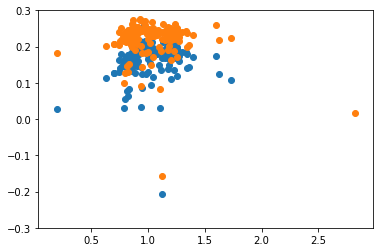

In [192]:
idx, d2d, _ = gsc.match_to_catalog_sky(sstarcat['coord'])
gcatmsk = gstarcat[d2d < 1*u.arcsec]
scatmsk = sstarcat[idx[d2d < 1*u.arcsec]]
ggmsk = gg[d2d<1*u.arcsec]

plt.scatter(gcatmsk['bp_rp'], gcatmsk['phot_g_mean_mag'] - scatmsk['r_mag'])
plt.scatter(gcatmsk['bp_rp'], ggmsk['Magnitude'] - scatmsk['r_mag'])
plt.ylim(-.3, .3)

That is strange.  Evans et al. 2018 would imply this should be ~ -0.1, not 0.2 to 0.3 ... unless this is a magnitude/SED effect?

In [194]:
gall = table.Table.read('external_catalogs/astrometric/nsa145729_gaia.ecsv')

/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Text(0,0.5,'$G_-r$')

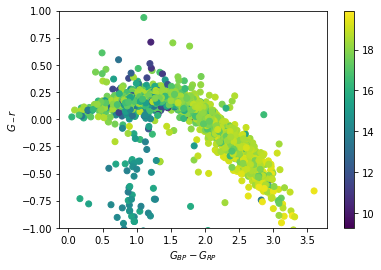

In [229]:
gmag = gall['phot_g_mean_mag']
gcut = gall[(gmag < 19)]
star_obj_cat = obj_cat[~obj_cat['is_galaxy']&(obj_cat['r_mag']>-9998)&(obj_cat['r_mag']<21)]
gsc = SkyCoord(gcut['ra'], gcut['dec'])
idx, d2d, _ = gsc.match_to_catalog_sky(star_obj_cat['coord'])

g_matches = gcut[d2d< 1*u.arcsec]
star_matches = star_obj_cat[idx[d2d< 1*u.arcsec]]

plt.scatter(g_matches['bp_rp'], g_matches['phot_g_mean_mag'] - star_matches['r_mag'], c=star_matches['r_mag'])
plt.ylim(-1, 1)
plt.colorbar()
plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$G_-r$')

... is extinction included in these r-mags?

In [241]:
host['A_r']

0.132215

Nope that's still not it...?

### Compare updated nsa3469 to the previous base catalog 

In [512]:
ocat = saga_object_catalog.load('nsa3469')[0]
ocat_old = table.Table.read('base_catalogs/backups/base_v2_nsa3469.fits.gz')

/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:54: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]


In [514]:
del ocat['coord'] # joins don't work with mixins

j = table.join(ocat, ocat_old, 'OBJID', 'outer')

In [536]:
notmatch = j[j['RA_1']!=j['RA_2']]
notmatch['OBJID', 'SATS_1', 'SATS_2']

OBJID,SATS_1,SATS_2
int64,int16,int16
667634,0,--
3066390000000001475,-1,--
3066390000000001476,--,-1
3095180000000004064,--,-1
3109520000000002200,--,-1
3109520000000002201,-1,--
3109530000000000033,--,-1
3109530000000000035,-1,--
3109530000000003600,--,-1


In [549]:
nsat = notmatch[0]
nsat

OBJID,RA_1,DEC_1,REMOVE_1,is_galaxy_1,morphology_info_1,radius_1,radius_err_1,u_mag_1,g_mag_1,r_mag_1,i_mag_1,z_mag_1,y_mag_1,u_err_1,g_err_1,r_err_1,i_err_1,z_err_1,y_err_1,survey_1,OBJID_sdss_1,RA_sdss_1,DEC_sdss_1,REMOVE_sdss_1,is_galaxy_sdss_1,morphology_info_sdss_1,radius_sdss_1,radius_err_sdss_1,u_mag_sdss_1,g_mag_sdss_1,r_mag_sdss_1,i_mag_sdss_1,z_mag_sdss_1,y_mag_sdss_1,u_err_sdss_1,g_err_sdss_1,r_err_sdss_1,i_err_sdss_1,z_err_sdss_1,y_err_sdss_1,OBJID_decals_1,RA_decals_1,DEC_decals_1,REMOVE_decals_1,is_galaxy_decals_1,morphology_info_decals_1,radius_decals_1,radius_err_decals_1,u_mag_decals_1,g_mag_decals_1,r_mag_decals_1,i_mag_decals_1,z_mag_decals_1,y_mag_decals_1,u_err_decals_1,g_err_decals_1,r_err_decals_1,i_err_decals_1,z_err_decals_1,y_err_decals_1,HOST_NSAID_1,HOST_NSA1ID_1,HOST_RA_1,HOST_DEC_1,HOST_DIST_1,HOST_VHOST_1,HOST_MK_1,HOST_MR_1,HOST_MG_1,HOST_SAGA_NAME_1,HOST_NGC_1,HOST_PGC_1,RHOST_ARCM_1,RHOST_KPC_1,OBJ_NSAID_1,SPEC_REPEAT_1,SPEC_Z_1,SPEC_Z_ERR_1,ZQUALITY_1,SPECOBJID_1,MASKNAME_1,TELNAME_1,EM_ABS_1,HELIO_CORR_1,RA_spec_1,DEC_spec_1,sb_r_1,SATS_1,log_sm_1,ug,ug_err,gr,gr_err,ri,ri_err,iz,iz_err,zy,zy_err,rz,rz_err,RA_2,DEC_2,REMOVE_2,is_galaxy_2,morphology_info_2,radius_2,radius_err_2,u_mag_2,g_mag_2,r_mag_2,i_mag_2,z_mag_2,y_mag_2,u_err_2,g_err_2,r_err_2,i_err_2,z_err_2,y_err_2,survey_2,OBJID_sdss_2,RA_sdss_2,DEC_sdss_2,REMOVE_sdss_2,is_galaxy_sdss_2,morphology_info_sdss_2,radius_sdss_2,radius_err_sdss_2,u_mag_sdss_2,g_mag_sdss_2,r_mag_sdss_2,i_mag_sdss_2,z_mag_sdss_2,y_mag_sdss_2,u_err_sdss_2,g_err_sdss_2,r_err_sdss_2,i_err_sdss_2,z_err_sdss_2,y_err_sdss_2,OBJID_decals_2,RA_decals_2,DEC_decals_2,REMOVE_decals_2,is_galaxy_decals_2,morphology_info_decals_2,radius_decals_2,radius_err_decals_2,u_mag_decals_2,g_mag_decals_2,r_mag_decals_2,i_mag_decals_2,z_mag_decals_2,y_mag_decals_2,u_err_decals_2,g_err_decals_2,r_err_decals_2,i_err_decals_2,z_err_decals_2,y_err_decals_2,HOST_NSAID_2,HOST_NSA1ID_2,HOST_RA_2,HOST_DEC_2,HOST_DIST_2,HOST_VHOST_2,HOST_MK_2,HOST_MR_2,HOST_MG_2,HOST_SAGA_NAME_2,HOST_NGC_2,HOST_PGC_2,RHOST_ARCM_2,RHOST_KPC_2,OBJ_NSAID_2,SPEC_REPEAT_2,SPEC_Z_2,SPEC_Z_ERR_2,ZQUALITY_2,SPECOBJID_2,MASKNAME_2,TELNAME_2,EM_ABS_2,HELIO_CORR_2,RA_spec_2,DEC_spec_2,sb_r_2,SATS_2,log_sm_2
int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,str6,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,str48,int32,int32,float32,float32,int32,str48,float32,float32,int16,str48,str48,str6,int16,bool,float64,float64,float32,int16,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,bytes6,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,bytes48,int32,int32,float32,float32,int32,bytes48,float32,float32,int16,bytes48,bytes48,bytes6,int16,bool,float64,float64,float32,int16,float64
667634,186.28988312104642,-3.650951666385364,0,True,69,3.2260087,0.0,20.403911590576172,20.104137,19.667616,19.071447372436523,19.019974,99.0,0.2365889996290207,0.089075685,0.08529498,0.08152511715888977,0.28358462,99.0,NSA,1237650760245838115,186.28914357117526,-3.6518246779813537,0,True,3,2.2175121,0.07880783,20.13367462

In [550]:
nsatsc = SkyCoord(nsat['RA_1'], nsat['DEC_1'], unit=u.deg)
oldsc = SkyCoord(ocat_old['RA'], ocat_old['DEC'], unit=u.deg)

seps = nsatsc.separation(oldsc)
print('min', np.min(seps.arcsec))
ocat_old[np.argmin(seps)]

min 4.0696631248491855


OBJID,RA,DEC,REMOVE,is_galaxy,morphology_info,radius,radius_err,u_mag,g_mag,r_mag,i_mag,z_mag,y_mag,u_err,g_err,r_err,i_err,z_err,y_err,survey,OBJID_sdss,RA_sdss,DEC_sdss,REMOVE_sdss,is_galaxy_sdss,morphology_info_sdss,radius_sdss,radius_err_sdss,u_mag_sdss,g_mag_sdss,r_mag_sdss,i_mag_sdss,z_mag_sdss,y_mag_sdss,u_err_sdss,g_err_sdss,r_err_sdss,i_err_sdss,z_err_sdss,y_err_sdss,OBJID_decals,RA_decals,DEC_decals,REMOVE_decals,is_galaxy_decals,morphology_info_decals,radius_decals,radius_err_decals,u_mag_decals,g_mag_decals,r_mag_decals,i_mag_decals,z_mag_decals,y_mag_decals,u_err_decals,g_err_decals,r_err_decals,i_err_decals,z_err_decals,y_err_decals,HOST_NSAID,HOST_NSA1ID,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_SAGA_NAME,HOST_NGC,HOST_PGC,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SPEC_REPEAT,SPEC_Z,SPEC_Z_ERR,ZQUALITY,SPECOBJID,MASKNAME,TELNAME,EM_ABS,HELIO_CORR,RA_spec,DEC_spec,sb_r,SATS,log_sm
int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,bytes6,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int64,float64,float64,int64,bool,int32,float32,float32,float64,float32,float32,float64,float32,float64,float64,float32,float32,float64,float32,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,bytes48,int32,int32,float32,float32,int32,bytes48,float32,float32,int16,bytes48,bytes48,bytes6,int16,bool,float64,float64,float32,int16,float64
3095180000000004064,186.2892062262206,-3.6518580967675636,0,True,69,2.5225127,9999.0,99.0,19.241293,18.812649,99.0,18.501104,99.0,99.0,0.005536317,0.0049096895,99.0,0.008456782,99.0,decals,1237650760245838115,186.28914357117526,-3.6518246779813537,0,True,3,2.2175121,0.07880783,20.13367462158203,19.20518,18.841427,18.57540512084961,18.406008,99.0,0.10479016602039337,0.022609735,0.02977314,0.029728418216109276,0.09791481,99.0,3095180000000004064,186.2892062262206,-3.6518580967675636,0,True,69,2.5225127,9999.0,99.0,19.241293,18.812649,99.0,18.501104,99.0,99.0,0.005536317,0.0049096895,99.0,0.008456782,99.0,3469,19609,185.975,-3.44293,29.8369,2004.28,-23.4597,-20.4264,-19.6124,,4348,40284,22.609608,196.23195,-1,,nan,nan,-1,,,,-1,False,nan,nan,22.817265,-1,nan


In [544]:
ocat_old['OBJID'][np.argmin(seps)] in ocat['OBJID']

False

Curious.  The added object 667634 has the wrong coordinates...? But it's been removed

Now check the zquality's to ensure they are different for the observed objects

In [537]:
notmatch = j[j['ZQUALITY_1']!=j['ZQUALITY_2']]
notmatch['OBJID', 'ZQUALITY_1', 'ZQUALITY_2']


OBJID,ZQUALITY_1,ZQUALITY_2
int64,int16,int16
667634,4,--
1237650369410564480,2,-1
1237650369410564688,2,-1
1237650369410629877,4,-1
1237650369410629880,4,-1
1237650369410629892,4,-1
1237650369410629906,4,-1
1237650369410629925,4,-1
1237650369410630114,3,-1
